In [8]:
import numpy as np
import pandas as pd
from context_analysis.load import load_traces, load_mice, load_spikes, load_behaviour
from context_analysis.utils import split_by_group
from context_analysis.onep.preprocessing import get_pivoted_X, block_from_time, remove_nan_ys, remove_mixed_ys
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def fit_model(df: pd.DataFrame, pipe: Pipeline, session_name: str, resample_interval: str ="500ms"):
    X = get_pivoted_X(df, downsample_interval=resample_interval)
    y = block_from_time(X.reset_index(), session_name=session_name,)
    X, y = remove_nan_ys(X, y)
    X, y = remove_mixed_ys(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    return score, pipe, np.array(X_train.columns)

def get_model_coefs(model: BaseEstimator, cells: np.array):
    coefs = model.coef_.flatten()
    return pd.DataFrame({"cell": cells, "coef": coefs})

### Decode Context

#### Test 1

In [3]:
session_name = "day4-test1"

In [4]:
traces_test1 = load_traces(experiment="pfc", session_names=[session_name])

In [5]:
exp, one, no = split_by_group(traces_test1)

In [6]:
resample_interval = "500ms"
num_splits = 10

clf = LogisticRegression(C=0.01, penalty="elasticnet", solver='saga', l1_ratio=0.3)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("clf", clf)
])

In [11]:
exp_score, exp_pipe, exp_cells = fit_model(exp, clone(pipe), session_name=session_name, resample_interval=resample_interval)
one_score, one_pipe, one_cells = fit_model(one, clone(pipe), session_name=session_name, resample_interval=resample_interval)
no_score, no_pipe, no_cells = fit_model(no, clone(pipe), session_name=session_name, resample_interval=resample_interval)

scores_test1 = pd.Series({"exp": exp_score, "one_context": one_score, "no_shock": no_score})
models_test1 = {"exp": exp_pipe, "one_context": one_pipe, "no_shock": no_pipe}
cells_test1 = {"exp":exp_cells, "one_context":one_cells, "no_shock": no_cells}

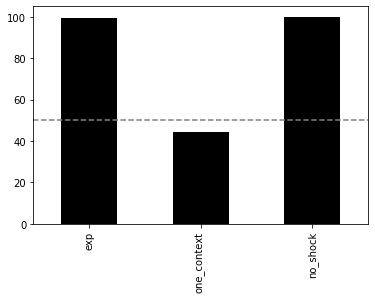

In [12]:
ax = scores_test1.mul(100).plot(kind="bar", color="black")
ax.axhline(50, color="grey", linestyle="dashed")

#### Test 2

In [13]:
session_name = "day5-test2"

In [14]:
traces_test2 = load_traces(experiment="pfc", session_names=[session_name])

In [15]:
exp, one, no = split_by_group(traces_test2)

In [16]:
resample_interval = "500ms"
num_splits = 10

clf = LogisticRegression(C=0.01, penalty="elasticnet", solver='saga', l1_ratio=0.2)
pipe = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler()),
    ("clf", clf)
])

In [17]:
exp_score, exp_pipe, exp_cells = fit_model(exp, clone(pipe), session_name=session_name, resample_interval=resample_interval)
one_score, one_pipe, one_cells = fit_model(one, clone(pipe), session_name=session_name, resample_interval=resample_interval)
no_score, no_pipe, no_cells = fit_model(no, clone(pipe), session_name=session_name, resample_interval=resample_interval)

scores_test2 = pd.Series({"exp": exp_score, "one_context": one_score, "no_shock": no_score})
models_test2 = {"exp": exp_pipe, "one_context": one_pipe, "no_shock": no_pipe}
cells_test2 = {"exp":exp_cells, "one_context":one_cells, "no_shock": no_cells}

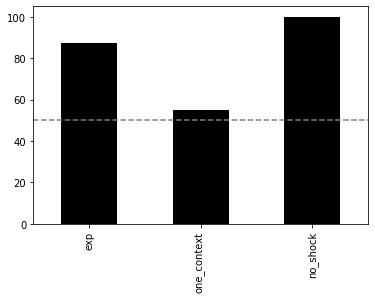

In [18]:
ax = scores_test2.mul(100).plot(kind="bar", color="black")
ax.axhline(50, color="grey", linestyle="dashed")

### Investigate Context Cells

In [19]:
def num_non_zero(ser):
    return np.sum(ser != 0)

In [20]:
coef_dfs = {}
for group in ["exp", "no_shock", "one_context"]:
    coef_dfs[group] = get_model_coefs(model=models_test2[group]["clf"], cells=cells_test2[group])


exp = num_non_zero(coef_dfs["exp"]["coef"])
exp / len(coef_dfs["exp"])

0.34156378600823045

In [21]:
one = num_non_zero(coef_dfs["one_context"]["coef"])
one

134

In [22]:
no = num_non_zero(coef_dfs["no_shock"]["coef"])
no / len(coef_dfs["no_shock"])

0.08289241622574955

In [23]:
no_shock = coef_dfs["no_shock"]

In [24]:
idx = no_shock.loc[lambda x: x.coef != 0].cell.values

In [25]:
traces_test2.loc[lambda x: x.cell_id.isin(idx)][["mouse", "cell_id"]].drop_duplicates().groupby("mouse").apply(len)

mouse
B51622     2
B58215    20
B58216    13
B58217    12
dtype: int64